In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os

In [2]:
df = pd.read_csv('review2019.csv',encoding = 'unicode_escape')


In [3]:
df.count()

listing_id    12531
id            12531
date          12531
comments      12531
dtype: int64

In [4]:
df2 = df.dropna()
df.head()

,listing_id,id,date,comments
0,44077.0,419600626.0,3/4/2019,We had a great stay at the cottage. We loved t...
1,44077.0,421384918.0,3/9/2019,Teresa and her husband are a wonderful and war...
2,44077.0,427270205.0,3/23/2019,Great place to stay if you want the experience...
3,44077.0,430911992.0,3/31/2019,Very welcoming home and kind hosts. We had a v...
4,44077.0,438341286.0,4/16/2019,Welcoming and flexible host. Nice stay in Dublin.


In [5]:
df2['comments'] = df2['comments'].apply(lambda row: row.encode('ascii',errors='ignore').decode())

C:\Users\heath\Anaconda3\envs\base3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
df2.count()

listing_id    12531
id            12531
date          12531
comments      12531
dtype: int64

## Preprocessing through Tokenizing and using TFIDF

In [7]:
### nltk and string transformations
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string

### sklearn
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score
import nltk
# nltk.download('vader_lexicon')
### numpy for seed.  Good practice for reproducibility, not something we touched on but worth wild to look further.
import numpy as np
from numpy import random

SEED = 1234

random.seed(SEED)

Before anything we need to take raw text and convert to numerical inputs for the machine learning algorithms.

The first step is to split the sentences into words, we will do this through a method of Tokenization (or splitting).

In [8]:
### Define simple space tokenizer
translator = str.maketrans('', '', string.punctuation)
tk = tokenize.simple.SpaceTokenizer()

def simple_tokenizer(x):
    x = x.translate(translator).strip().lower()
    return tk.tokenize(x)

### Quick look at what the tokenizer produces
print(df2['comments'].head().apply(lambda x : simple_tokenizer(x)))
#df['polarity'] = df['comments']
analyzer = SentimentIntensityAnalyzer()

df2['polarity']=df2['comments'].apply(lambda x : str(analyzer.polarity_scores(x)["compound"]))
### Developing the corpus or list of sentences for processing later
corpus = df2['comments'].tolist()



0    [we, had, a, great, stay, at, the, cottage, we...
1    [teresa, and, her, husband, are, a, wonderful,...
2    [great, place, to, stay, if, you, want, the, e...
3    [very, welcoming, home, and, kind, hosts, we, ...
4    [welcoming, and, flexible, host, nice, stay, i...
Name: comments, dtype: object


C:\Users\heath\Anaconda3\envs\base3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
df2['class'] = df2['polarity'].astype(float).apply(lambda x : 'positive' if x > 0.0 else 'negative')

class_names = ['negative', 'positive']

# df2['polarity'] = df2['polarity'].astype(float)

C:\Users\heath\Anaconda3\envs\base3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df2['polarity2'] = df2['polarity'].astype(float).apply(lambda x : 1 if x > 0.0 else 0)

C:\Users\heath\Anaconda3\envs\base3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


We will now use the tokenizer within the TFIDF vectorizer.  The words might sound intimidating yet simply yet in reality basically we just counting the number of times a words occur within the sentence relative to the whole sample (sometimes called a corpus).

In [11]:
df2.head()

,listing_id,id,date,comments,polarity,class,polarity2
0,44077.0,419600626.0,3/4/2019,We had a great stay at the cottage. We loved t...,0.9081,positive,1
1,44077.0,421384918.0,3/9/2019,Teresa and her husband are a wonderful and war...,0.9878,positive,1
2,44077.0,427270205.0,3/23/2019,Great place to stay if you want the experience...,0.6597,positive,1
3,44077.0,430911992.0,3/31/2019,Very welcoming home and kind hosts. We had a v...,0.9199,positive,1
4,44077.0,438341286.0,4/16/2019,Welcoming and flexible host. Nice stay in Dublin.,0.765,positive,1


In [13]:
vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english')
tf = vectorizer.fit(corpus)
X = tf.transform(corpus)
#remove polarity and class listingid
### Combining result of TFIDF with `target` columns
full_df = pd.concat([pd.DataFrame(X.toarray()), df2['polarity2']], axis=1)
print("Vector features : ", vectorizer.get_feature_names())
print("Vector shape/size : ",X.shape)

Vector features :  ['', '\tan', '\n', '\n\tare', '\n\tstay', '\n\tthere', '\n\twe', '\n\n', '\n\n\namazing', '\n\n\noverall\nall', '\n\n1010', '\n\n2', '\n\n2\tbad', '\n\n3', '\n\n4', '\n\n4\thorrible', '\n\n5\t', '\n\n7\tdirty', '\n\n8\tnoise', '\n\na', '\n\nabout', '\n\nabsolute', '\n\naccess', '\n\nagain', '\n\nall', '\n\nalso', '\n\nalthough', '\n\nand', '\n\nanne', '\n\napartment', '\n\nas', '\n\nask', '\n\nawesome', '\n\nbe', '\n\nbeautiful', '\n\nbed', '\n\nbob', '\n\nbreakfast', '\n\nbridgette', '\n\nbut', '\n\nbuy', '\n\ncal', '\n\ncan', '\n\ncars', '\n\ncatherine', '\n\ncheckin', '\n\nchecking', '\n\nchris', '\n\ncleanliness', '\n\nclose', '\n\ncommunal', '\n\ncommunication', '\n\nconnecting', '\n\nconor', '\n\ncons', '\n\ncouch', '\n\ncouple', '\n\ncowper', '\n\ndaragh', '\n\ndardo', '\n\ndefinitely', '\n\ndes', '\n\ndo', '\n\ndont', '\n\ndorothy', '\n\ndublin', '\n\nduring', '\n\neasy', '\n\nelaine', '\n\nenjoyable', '\n\neven', '\n\neverything', '\n\nexcellent', '\n\nfallo

In [14]:
full_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14981,14982,14983,14984,14985,14986,14987,14988,14989,polarity2
0,0.104991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [15]:
target_col = 'polarity2'
y =df2[target_col]
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(target_col , axis=1),y, test_size=0.20, random_state=SEED)
print(X_train.shape, y_train.shape)

(10024, 14990) (10024,)


In [16]:
polarity_count = df2["polarity2"].sum()
polarity_count

11884

In [17]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,14980,14981,14982,14983,14984,14985,14986,14987,14988,14989
6045,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8205,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6966,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6099,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7242,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4458,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.575914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2046,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Training and Analysis

**Helper Function**  : This is a simple helper function modified from the sklearn [documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).  Example below.  Parameters required are the actual labels (y_true), the predicted labels (y_pred), classes in a list like `["good", "bad", "ugly"]`.  Options are using `normalize` to get percentages, `include_cm` to print off the raw confusion matrix, and `fig_size` for the size of the plot.

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          include_cm=False,
                          fig_size=(10, 8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if include_cm:
        print(cm)

    fig, ax = plt.subplots(figsize=fig_size)
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Lets use a base model to get a baseline prediction.

In [19]:
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [20]:
confusion_matrix(y_test, y_pred)

array([[  37,   85],
       [   4, 2381]], dtype=int64)

In [21]:
print("Accuracy of base model is {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy of base model is 96.45 %


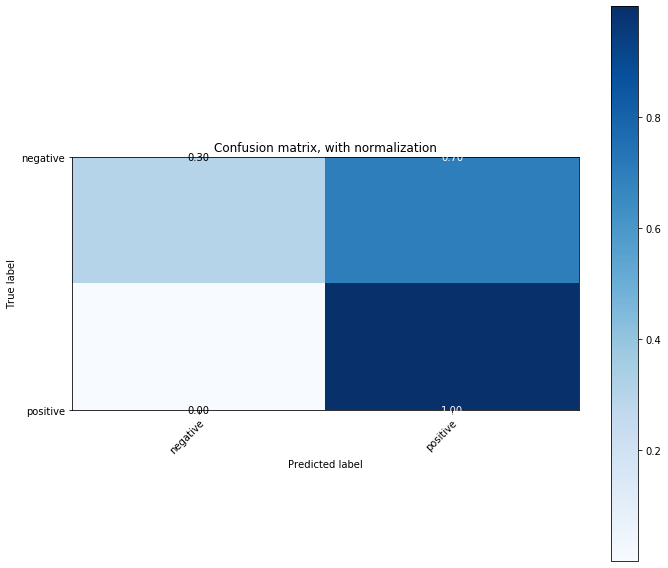

In [22]:
### Plot confusion matrix to get a feel for model ability to predict correct label.
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization', fig_size=(10, 8));

**Another try**, let's try out using a Random Forest model.

In [23]:
clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=SEED).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [24]:
confusion_matrix(y_test, y_pred)

array([[   0,  122],
       [   0, 2385]], dtype=int64)

In [25]:
print("Accuracy of base model is {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy of base model is 95.13 %


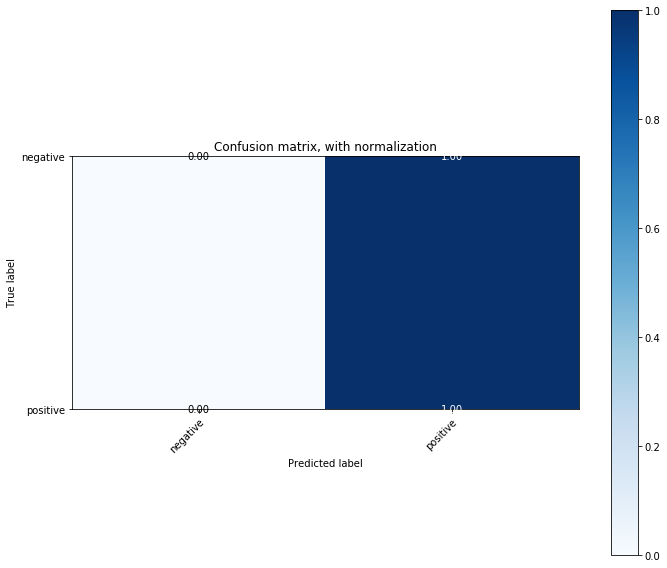

In [26]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization', fig_size=(10, 8));

## Single Input Examples

In [ ]:
review = "Best tacos I have ever had, will come back every Tuesday.  Will never go to any other taco shop again."

### Transform Review
review_transformed = tf.transform([review])

### Make Prediction
pred = clf.predict(review_transformed)

### Using the defined `class_names` get the predicted Polarity ( negative/positive )
print("Review was {}".format(class_names[pred[0]]))


## Extra Extra Content : Comparing Multiple Models Side by Side

Example found [here](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f).  Interesting final reference.

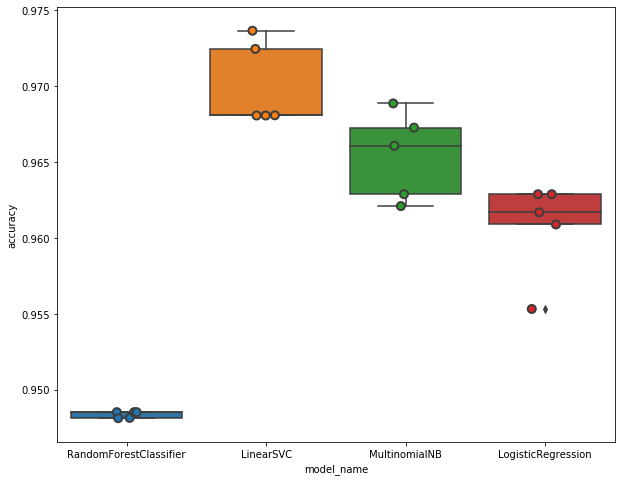

In [27]:
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=8, random_state=SEED),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

### Gather all features (X values) and labels (y values) to pass through cross validation
features = full_df.drop(target_col, axis=1)
labels = df2[target_col].values

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()